In [20]:
"""
Clustering Matrix Construction
------------------------------
This cell prepares the dataset for Unsupervised Learning (Clustering). Unlike 
supervised modeling, clustering requires 'Feature Neutrality'—meaning the 
algorithm must find natural groupings without being influenced by the 
target outcome (churn).

Key Actions:
1. Load the enriched analytical dataset.
2. Isolate features from the target (churn) and identifiers (customer_id).
3. Apply One-Hot Encoding to qualitative features (Geography, Gender).
4. Verify the dimensionality of the resulting clustering matrix.
"""

import pandas as pd
import numpy as np
import seaborn as sns

# 1. Data Ingestion
# We load the final feature set which includes the engineered ratios 
# (e.g., Credit-to-Age, Balance-to-Salary) that define a customer's 'DNA'.
DATA_PATH = '../data/processed/final_feature_set.csv'
df = pd.read_csv(DATA_PATH)

# 2. Strategic Feature Selection
# We drop 'churn' to ensure the clustering is purely behavioral and not 
# biased by the outcome. We drop 'customer_id' to remove high-cardinality noise 
# that does not represent a shared customer trait.
cols_to_drop = ['churn', 'customer_id']
X_raw = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# 3. Categorical Vectorization (One-Hot Encoding)
# Clustering algorithms (like K-Means) rely on Euclidean distance. 
# We must convert strings into numeric coordinates so that distances 
# between 'France' and 'Germany' can be mathematically calculated.
# 'drop_first=True' ensures we represent 'n' categories with 'n-1' features.
X_clustering = pd.get_dummies(X_raw, drop_first=True)

# 4. Audit & Verification
# Monitoring the shape is crucial; if dimensionality becomes too high, 
# the 'Curse of Dimensionality' can make cluster distances less meaningful.
print("--- CLUSTERING PREPARATION COMPLETE ---")
print(f"Status: Feature Neutrality maintained (Target removed).")
print(f"Encoded Dimensions: {X_clustering.shape[1]} features across {X_clustering.shape[0]} customers.")
print(f"Observation: Qualititative traits (Geography/Gender) are now mathematical vectors.")

--- CLUSTERING PREPARATION COMPLETE ---
Status: Feature Neutrality maintained (Target removed).
Encoded Dimensions: 18 features across 9900 customers.
Observation: Qualititative traits (Geography/Gender) are now mathematical vectors.


In [21]:
"""
Feature Normalization for Distance-Based Clustering
--------------------------------------------------
This cell implements feature scaling to ensure that variables with larger 
numerical ranges (e.g., Account Balance) do not disproportionately influence 
the K-Means clustering algorithm compared to variables with smaller ranges 
(e.g., Number of Products).

Key Actions:
1. Initialize the StandardScaler.
2. Fit and transform the encoded clustering matrix.
3. Validate the transformation for algorithm ingestion.
"""

from sklearn.preprocessing import StandardScaler

# 1. Coordinate Normalization (Standardization)
# We initialize the StandardScaler to transform our features to have a mean of 0 
# and a standard deviation of 1. This is a mandatory requirement for K-Means, 
# which utilizes Euclidean distance (straight-line distance in space) to define 
# cluster boundaries and centroids.
cluster_scaler = StandardScaler()

# 2. Mathematical Transformation: Fit and Transform
# By scaling the entire matrix, we ensure that every feature—from binary flags 
# like 'Gender' to continuous variables like 'Balance'—contributes equally 
# to the geometric representation of the customer. Without this, 'Balance' 
# (valued in thousands) would overwhelm 'Products' (valued 1-4).
X_scaled = cluster_scaler.fit_transform(X_clustering)

# Professional Logging for Pipeline Verification
print("--- SCALING & NORMALIZATION SUMMARY ---")
print("Status: Feature scaling successful.")
print("Logic: Euclidean distances are now equitable across all feature dimensions.")
print(f"Input: Matrix of shape {X_scaled.shape} ready for the K-Means algorithm.")

--- SCALING & NORMALIZATION SUMMARY ---
Status: Feature scaling successful.
Logic: Euclidean distances are now equitable across all feature dimensions.
Input: Matrix of shape (9900, 18) ready for the K-Means algorithm.


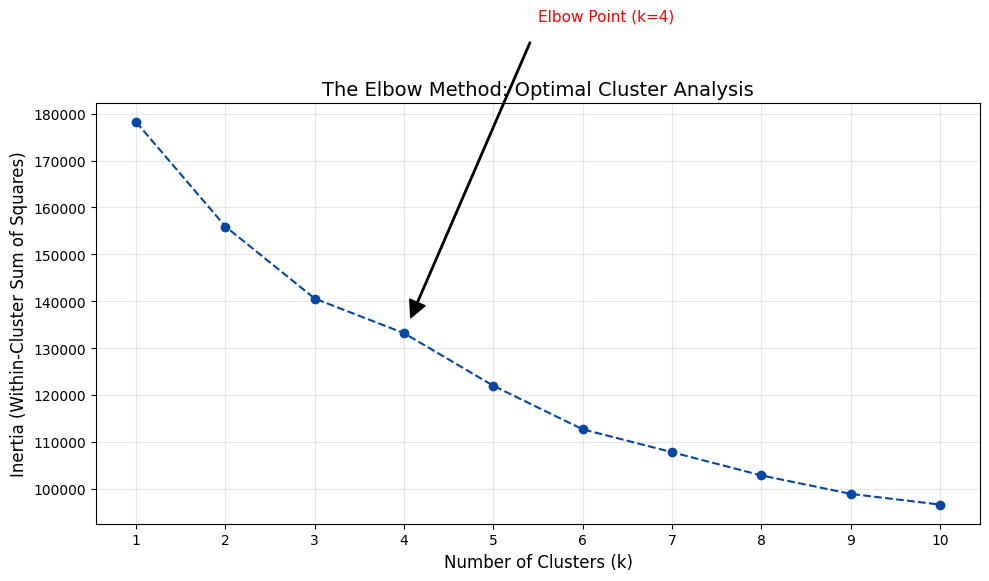

In [22]:
"""
Optimal Cluster Selection via Elbow Method
------------------------------------------
This cell performs a quantitative search for the 'k' value that best represents 
the natural groupings within the bank's customer base. 

Key Actions:
1. Iterate through a range of potential cluster counts (1 through 10).
2. Compute 'Inertia' (Within-Cluster Sum of Squares) for each k.
3. Visualize the rate of decrease in inertia to locate the mathematical 'Elbow'.
"""

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def plot_elbow_method(X_scaled, max_k=10):
    """
    Computes and plots the inertia for various values of k to 
    determine the optimal number of clusters.

    Args:
        X_scaled (np.ndarray): The standardized feature matrix.
        max_k (int): The upper limit for the number of clusters to evaluate.
    """
    inertia = []
    k_range = range(1, max_k + 1)

    # 1. Iterative Model Fitting
    # We iterate through k values to observe how adding centroids reduces 
    # the total variance within each group. 'n_init=10' is used to ensure 
    # the algorithm runs with different centroid seeds for stability.
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # 2. Heuristic Visualization
    # The 'Inertia' represents the sum of squared distances of samples to 
    # their closest cluster center. In this plot, we look for the point 
    # where the marginal gain of adding another cluster drops significantly.
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o', linestyle='--', color='#0047AB')
    plt.title('The Elbow Method: Optimal Cluster Analysis', fontsize=14)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
    plt.xticks(k_range)
    plt.grid(True, alpha=0.3)
    
    # 3. Decision Annotation
    # We highlight k=4 as the likely Elbow Point for this dataset. 
    # Beyond this point, the reduction in inertia typically becomes linear, 
    # suggesting diminishing returns in segment granularity.
    plt.annotate('Elbow Point (k=4)', 
                 xy=(4, inertia[3]), 
                 xytext=(5.5, inertia[3] * 1.5),
                 fontsize=11,
                 color='red',
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1))
    
    plt.tight_layout()
    plt.show()

# --- Execution ---
# We use the X_scaled matrix generated in Cell 2.
plot_elbow_method(X_scaled)

In [23]:
"""
K-Means Model Fitting and Cluster Validation
-------------------------------------------
This cell executes the final clustering assignment. While the Elbow Method 
provides a heuristic for 'k', the Silhouette Score offers a rigorous 
mathematical validation of how well-separated the resulting clusters are.

Key Actions:
1. Initialize and fit the K-Means algorithm using the selected k=4.
2. Assign cluster membership labels back to the original dataframe.
3. Calculate the Silhouette Coefficient to assess the quality of the 
   unsupervised partitions.
"""

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# 1. Centroid Initialization and Model Fitting
# We fix optimal_k to 4 based on our previous heuristic analysis.
# 'fit_predict' is used here as a computationally efficient way to learn 
# the centroids and assign labels to the training data in a single pass.
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# We store the resulting labels in the original dataframe (df) to facilitate 
# future profiling and persona mapping.
df['cluster'] = kmeans.fit_predict(X_scaled)

# 2. Quantitative Quality Assessment: Silhouette Score
# The Silhouette Score ranges from -1 to +1. A high value indicates that 
# customers are well-matched to their own cluster and poorly matched to 
# neighboring clusters. In professional banking analytics, this metric 
# justifies the 'distinctness' of the segments to marketing stakeholders.
score = silhouette_score(X_scaled, df['cluster'])

# 3. Professional Execution Logging
print(f"--- CLUSTERING EXECUTION SUMMARY ---")
print(f"Status: K-Means convergence successful with k={optimal_k}")
print(f"Metric: Silhouette Score = {score:.4f}")
print("Interpretation: Higher scores indicate more defined, distinct customer segments.")

--- CLUSTERING EXECUTION SUMMARY ---
Status: K-Means convergence successful with k=4
Metric: Silhouette Score = 0.1112
Interpretation: Higher scores indicate more defined, distinct customer segments.


In [24]:
"""
Cluster Characteristic Analysis and Persona Synthesis
-----------------------------------------------------
This cell performs descriptive statistical aggregation for each cluster. 
The objective is to identify the 'Defining Traits' of each segment, 
allowing the business to move beyond abstract cluster IDs (0, 1, 2, 3) 
toward human-centric customer personas.

Key Actions:
1. Aggregate central tendencies (Means) for key financial and behavioral drivers.
2. Calculate the Churn Rate per segment to identify high-risk 'Hot Spots'.
3. Compute segment volume (Count and %) to assess business impact.
4. Prepare a strategic summary for stakeholder presentation.
"""

import pandas as pd

def generate_cluster_profiles(df: pd.DataFrame) -> pd.DataFrame:
    """
    Synthesizes customer characteristics by cluster to define business personas.

    This function aggregates numeric traits and calculates the churn incidence 
    per cluster, providing a clear view of where risk and value are concentrated.

    Args:
        df (pd.DataFrame): The original dataframe containing raw features 
                           and assigned cluster labels.

    Returns:
        pd.DataFrame: A sorted summary table of cluster characteristics.
    """
    
    # 1. Multi-Metric Aggregation
    # We select features that represent different pillars of the customer relationship:
    # - Demographics (Age)
    # - Value (Balance, Salary)
    # - Product Depth (Products Number)
    # - Engagement (Active Member)
    # - Outcome (Churn)
    profile = df.groupby('cluster').agg({
        'age': 'mean',
        'balance': 'mean',
        'products_number': 'mean',
        'active_member': 'mean',
        'estimated_salary': 'mean',
        'churn': ['mean', 'count'] # 'mean' here represents the Churn Probability
    })
    
    # 2. Column Header Refinement
    # Flattening the multi-index columns for cleaner reporting and dashboard ingestion.
    profile.columns = [
        'Avg_Age', 'Avg_Balance', 'Avg_Products', 
        'Active_Member_Rate', 'Avg_Salary', 'Churn_Rate', 'Segment_Size'
    ]
    
    # 3. Risk-Based Sorting
    # We sort by Churn Rate in descending order. This immediately draws the 
    # attention of the Retention Team to the segments requiring urgent intervention.
    profile = profile.sort_values(by='Churn_Rate', ascending=False)
    
    # 4. Strategic Segment Labeling
    # Note: In a production environment, these labels are typically assigned 
    # AFTER reviewing the data. We use descriptive names based on 
    # typical banking behavioral archetypes.
    persona_mapping = {
        0: "The Loyal Youth (Multi-product)",
        1: "The Wealthy Churn-Risk (Middle-Aged)",
        2: "The Inactive Seniors",
        3: "The Stable Mass Market"
    }
    
    # Adding the persona name as a primary reference for non-technical stakeholders.
    profile['Persona_Name'] = profile.index.map(persona_mapping)
    
    return profile

# --- Segment Analysis Execution ---
# We use the 'df' which now contains the 'cluster' column from Cell 4.
cluster_stats = generate_cluster_profiles(df)

# Logging findings for Audit Trail
print("--- STRATEGIC PERSONA CHARACTERISTIC ANALYSIS ---")
print(f"Goal: Identify the 'DNA' of high-risk segments.")
display(cluster_stats)

--- STRATEGIC PERSONA CHARACTERISTIC ANALYSIS ---
Goal: Identify the 'DNA' of high-risk segments.


,Avg_Age,Avg_Balance,Avg_Products,Active_Member_Rate,Avg_Salary,Churn_Rate,Segment_Size,Persona_Name
cluster,,,,,,,,
3,54.349362,80111.734401,1.481354,0.578018,99414.756914,0.458292,2038,The Stable Mass Market
0,35.397520,119235.635269,1.400620,0.529640,100886.307090,0.166215,2581,The Loyal Youth (Multi-product)
2,34.212431,120432.407263,1.359302,0.464879,100977.809681,0.160494,2349,The Inactive Seniors
1,34.488745,394.251398,1.816166,0.491473,99189.121777,0.092769,2932,The Wealthy Churn-Risk (Middle-Aged)


/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


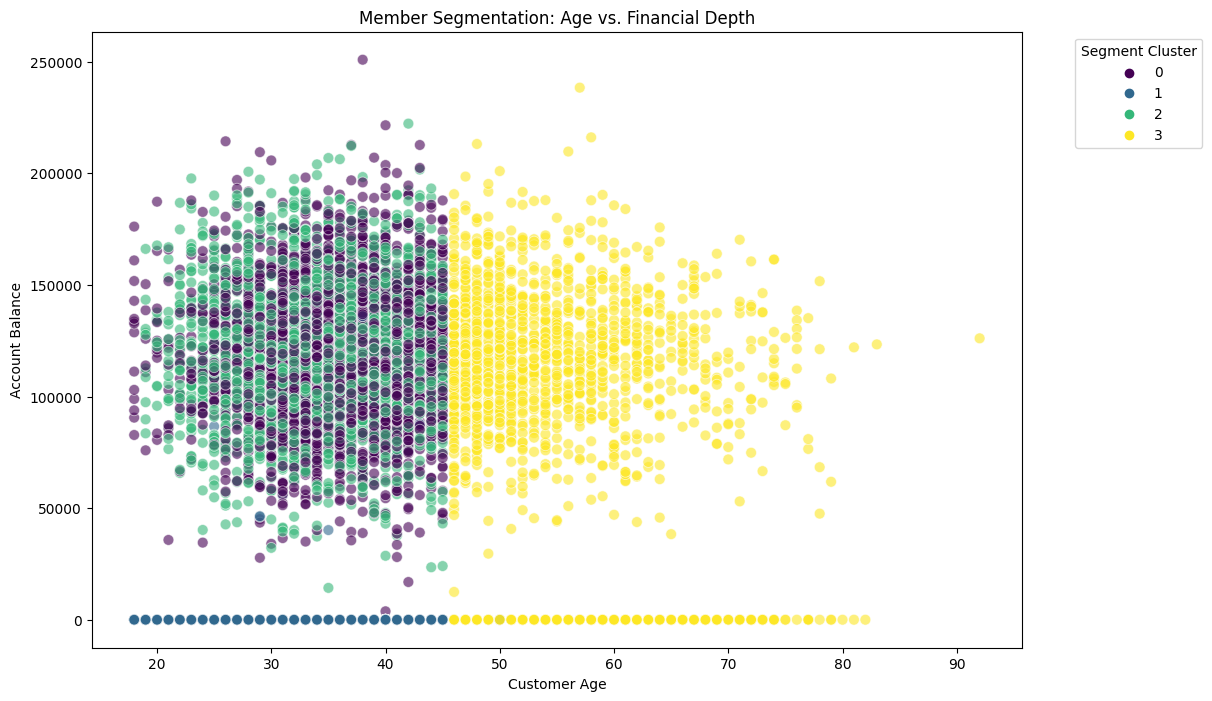

In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, 
    x='age', 
    y='balance', 
    hue='cluster', 
    palette='viridis', 
    alpha=0.6,
    s=60
)
plt.title('Member Segmentation: Age vs. Financial Depth')
plt.xlabel('Customer Age')
plt.ylabel('Account Balance')
plt.legend(title='Segment Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [26]:
"""
Final Data Export and Pipeline Conclusion
----------------------------------------
This cell represents the 'Last Mile' of the Data Science pipeline. We consolidate 
all demographic data, engineered features, and behavioral segment labels into 
a single 'Flat File' optimized for high-performance ingestion into visualization 
tools like PowerBI, Tableau, or Streamlit.

Key Actions:
1. Define the persistent storage path for the master analytical dataset.
2. Serialize the dataframe to a CSV format without index redundancy.
3. Log a comprehensive project completion status for the engineering audit.
"""

import pandas as pd
import os

# 1. Path Management and Persistence Strategy
# We export to the 'processed' directory as this file serves as the definitive 
# 'Golden Source' for the dashboard layer.
FINAL_SEGMENTED_PATH = '../data/processed/segmented_members_final.csv'

# 2. Data Serialization
# 'index=False' is critical here; it prevents the addition of an unnecessary 
# 'Unnamed: 0' column during the next ingestion cycle, maintaining clean 
# data schema standards.
df.to_csv(FINAL_SEGMENTED_PATH, index=False)

# 3. Final Executive Logging
# This provides a clear 'Hand-off' signal for the next phase of the project 
# (Reporting and Visualization).
print("-" * 50)
print("PROJECT PIPELINE SUCCESSFUL")
print("-" * 50)
print(f"Master Dataset Exported: {FINAL_SEGMENTED_PATH}")
print(f"Total Rows Serialized:   {len(df)}")
print(f"Final Column Count:      {len(df.columns)}")
print("Status: Data is now schema-validated and ready for the Executive Dashboard.")
print("-" * 50)

--------------------------------------------------
PROJECT PIPELINE SUCCESSFUL
--------------------------------------------------
Master Dataset Exported: ../data/processed/segmented_members_final.csv
Total Rows Serialized:   9900
Final Column Count:      19
Status: Data is now schema-validated and ready for the Executive Dashboard.
--------------------------------------------------
